# Exploratory Data Analysis of Freelance Profiles with relation to Hourly Rate

In [1]:
# Notes to self:

# The clustering on skills didn't work because there isn't enough skills per user.
# Almost all users have about 5 skills, but there isn't enough overlap between them.
# Futhermore, there is just about no signal relating the features to hourly rate.
# Need to pivot and think of some alternative way to use this data.
# Also, I need to figure out why everyone has a "1" for their invoices paid.

# Do a regression tree model
# Deriving other features from the text
# Sentiment: Passive vs active voice?
# do the skills appear in the text 
# Try a targeted search and get numerics out
    # remove +'s' or try regex 
# Use text to look for those skills and maybe try to find words around it?
# Skills in text vs not in the skill list 
# Naively do some kind of embedding (word2vec)
    # Toss in their description and it creates a vector representation 
    # And then try looking at clusters in that space
    # Specify the length of the vector 

### Importing and Merging to get EDA Dataset

In [2]:
# Packages for PostgreSQL Import and Export
from sqlalchemy_utils import database_exists, create_database
from sqlalchemy import create_engine
import psycopg2
import os

# Packages for EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from nltk.corpus import stopwords
import re 

# Packages for K-Modes Cluster
from kmodes.kmodes import KModes

In [3]:
# Ideally I'll move this into the project config.py file
# Otherwise for now I have to just manually assign . . .

dbname = "freelance_db"
username = os.environ['USER']
pswd = os.environ['SQLPSWD']

# Connect to Data
con = None
con = psycopg2.connect(database=dbname, user=username,
                       host='localhost', password=pswd)

# Checking shapes of tables
sql_query = """SELECT * from user_details_table;"""
dtls_table = pd.read_sql_query(sql_query, con)

sql_query = """SELECT * from freelance_table;"""
fl_table = pd.read_sql_query(sql_query, con)

In [4]:
# Merging
# Modifying profile_url in the details table so I can merge it with the fl_table
dtls_table['profile_url'] = "https://www.guru.com"+dtls_table['profile_url']

# Now I'm merging them together to make dt
dt = pd.merge(fl_table, dtls_table, on='profile_url')
dt.shape
dt = dt.drop(columns=(['index_x']))
dt = dt.drop_duplicates(subset='profile_url')

In [5]:
# Merging in data to crosswalk states with region labels
state_region_crswlk = pd.read_csv(
    '~/Desktop/Insight/projects/myrate/data/raw/census-regions/us census bureau regions and divisions.csv')
state_region_crswlk.head()

dt = pd.merge(dt, state_region_crswlk,
              how='left', left_on='state', right_on='State')

# Fixing region value for individuals living in Puerto Rico
dt.loc[dt['state'] == "Puerto Rico", 'Region'] = "Other"

In [6]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 978
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   profile_url       979 non-null    object
 1   city              979 non-null    object
 2   state             979 non-null    object
 3   country           979 non-null    object
 4   rating            979 non-null    object
 5   earnings          979 non-null    object
 6   hourly_rate       979 non-null    int64 
 7   skills_list       979 non-null    object
 8   user_description  979 non-null    object
 9   index_y           979 non-null    int64 
 10  member_since      979 non-null    object
 11  earnings_pst_yr   948 non-null    object
 12  earnings_ever     948 non-null    object
 13  employers         948 non-null    object
 14  invoices_paid     948 non-null    object
 15  largest_employ    948 non-null    object
 16  bio               948 non-null    object
 17  State           

# Exploratory Data Analysis - Outcome: Hourly Rate
### Beginning with investigating the geographic labels 

In [ ]:
# What is the overall mean?
print("Mean hourly rate ($):", round(dt['hourly_rate'].mean(), 2))

In [ ]:
# What is the mean by region?
dt.groupby(['Region']).hourly_rate.mean()

# There is some variation, but it is minimal

In [ ]:
# What is the mean across states?
dt.groupby(['state']).hourly_rate.mean().sort_values().describe()

# Pretty decent spread. This may be the most powerful signal yet.
# If you print out hte full table it is clear that there is variation

In [7]:
# What is the variation within states?
state_lvl_hourly_rate_descriptives = {}
state_lvl_hourly_rate_descriptives['min'] = dt.groupby(
    ['state']).hourly_rate.min()
state_lvl_hourly_rate_descriptives['mean'] = dt.groupby(
    ['state']).hourly_rate.mean()
state_lvl_hourly_rate_descriptives['max'] = dt.groupby(
    ['state']).hourly_rate.max()
state_lvl_hourly_rate_descriptives['var'] = dt.groupby(
    ['state']).hourly_rate.var()
dt_state_hr = pd.DataFrame(state_lvl_hourly_rate_descriptives)

# A decent amount of variation within the states

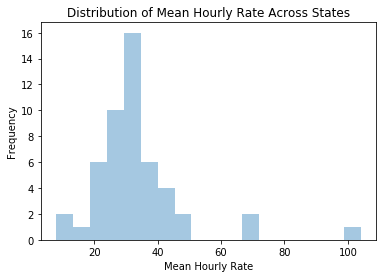

In [6]:
ax = sns.distplot(dt_state_hr['mean'], kde = False)
ax.set(xlabel='Mean Hourly Rate', ylabel='Frequency')
ax.set_title("Distribution of Mean Hourly Rate Across States")
plt.show()

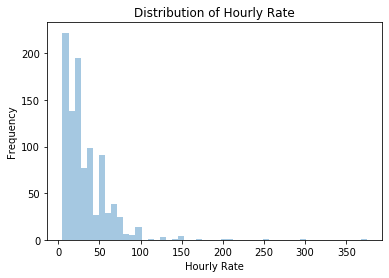

In [12]:
ax = sns.distplot(dt['hourly_rate'], kde = False)
ax.set(xlabel='Hourly Rate', ylabel='Frequency')
ax.set_title("Distribution of Hourly Rate")
plt.show()
fig = ax.get_figure()
fig.savefig("/Users/Metaverse/Desktop/Insight/presentation_materials/output.png") 


In [ ]:
# I tried to break it down further to the city level
# But the city data is really messy and not worth the time sink
# To try and get it set up. The idea would be to merge on
# rural vs urban and see if it can help me filter out a signal.

### Investigating the relationship between a users "rating" and the outcome

In [8]:
# Cleaing it up real quick
dt.rating = dt.rating.str.replace('%', '')
dt.rating = dt.rating.str.replace('NA', '')
dt.rating = pd.to_numeric(dt.rating)

In [7]:
# Starting with Missing Values
print("Number of missing values: ", dt.rating.isna().sum())

Number of missing values:  68


In [ ]:
# What does the spread look like for the rest?
dt.rating.describe()

# Basically no variation. Okay, let's make a binary variable (has_rating)

In [9]:
# Creating "has_rating"
dt['has_rating'] = None
dt.loc[dt['rating'].isna(), 'has_rating'] = 0
dt.loc[dt['rating'] > 0, 'has_rating'] = 1

# Comparing outcome means by has_rating
dt.groupby(['has_rating']).hourly_rate.mean()

# Small difference, nothing substantial

has_rating
0    34.529412
1    31.743139
Name: hourly_rate, dtype: float64

### Exploring the duration of membership and hourly rate

1. Convert member start date to a date object
2. Calculate years / months they've been a member (to today)

In [10]:
def date_convert(member_since):
    try:
        tmp = datetime.strptime(member_since, '%b, %Y')
        #tmp = tmp.strftime('%Y-%m')
    except:
        tmp = 'NaN'
    return tmp

In [11]:
def years_active(date):
    cur_year = datetime.now().year
    try:
        yrs_active = cur_year - date.year
    except:
        yrs_active = 'NaN'

    return yrs_active

In [12]:
def months_active(date):
    cur_year = datetime.now().year
    cur_month = datetime.now().month

    try:
        mnths_active = (cur_year - date.year)*12 + (cur_month - date.month)
    except:
        mnths_active = 'NaN'

    return mnths_active

In [13]:
# Converting member_since to date
dt.member_since = dt.member_since.str.strip()
dt['start_date'] = dt.member_since.apply(date_convert)
dt['years_active'] = dt.start_date.apply(years_active)
dt['months_active'] = dt.start_date.apply(months_active)

# Therea are 31 NAs. Just going to ignore them for now.

In [12]:
# What I want to understand is:
# How does the hourly rate (average) change across years active?
dt.groupby('years_active').hourly_rate.mean()

# Nothing much. It ramps up if years active > 17. Building that binary.

years_active
0.0     30.869565
1.0     32.279570
2.0     31.409091
3.0     31.804598
4.0     30.594203
5.0     30.295775
6.0     29.396552
7.0     23.527778
8.0     31.758621
9.0     24.173913
10.0    28.482759
11.0    28.192308
12.0    34.178571
13.0    32.521739
14.0    37.481481
15.0    38.652174
16.0    32.541667
17.0    51.190476
18.0    39.384615
19.0    42.533333
20.0    55.000000
Name: hourly_rate, dtype: float64

In [14]:
dt['active_17up'] = (dt['years_active'] >= 17) * 1

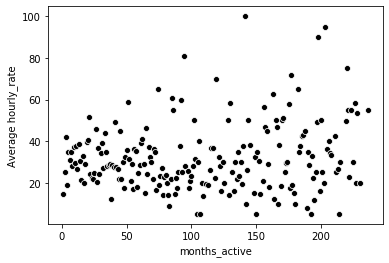

In [14]:
# Okay let's try looking at months active. Maybe on a finer scale there is some difference?
x = dt.groupby('months_active').hourly_rate.mean().index
y = dt.groupby('months_active').hourly_rate.mean()
ax = sns.scatterplot(x=x, y=y,
                     color='black')
ax.set(xlabel='months_active', ylabel='Average hourly_rate')
plt.show()

# No real pattern emerges. Unfortunately not useful.

### Exploring hourly rate and how it relates to the skills

1. Obtain the dataset that is long by skills and shrink it down to just the skills. I'll work with that for this.
2. Create some quick features such as: # of skills and top skill. These are user level so I can attach them back to dt to have everything in one place.

Note: the skills are standardized on guru which makes this more straightforward

In [15]:
sql_query = """SELECT profile_url, skills_list from freelance_table;"""
skills_table = pd.read_sql_query(sql_query, con)
skills_table_dummies = pd.get_dummies(skills_table, columns=[
                                      'skills_list'], prefix='').groupby(['profile_url']).sum()

In [16]:
# Number of skills
num_skills = skills_table.groupby('profile_url').count()
num_skills = num_skills.rename(columns={"skills_list": "num_skills"})
num_skills = num_skills.reset_index()

In [17]:
# Merging num skills into dt
dt = pd.merge(dt, num_skills, on="profile_url")

In [82]:
dt.groupby('num_skills').hourly_rate.mean()

num_skills
1    25.620690
2    42.600000
3    27.750000
4    24.381818
5    32.415854
Name: hourly_rate, dtype: float64

In [18]:
# Seems that for those with less than five skills listed
# they tend to have a lower hourly rate.
dt['less_five_skills'] = (dt['num_skills'] < 5) * 1

In [19]:
# Moving on to something else. Let's look at the top skills (first skill listed)
first_skill = skills_table[skills_table.groupby(
    'profile_url')['skills_list'].cumcount() == 0]

first_skill = first_skill.rename(
    columns={"profile_url": "profile_url", "skills_list": "first_skill"})

dt = pd.merge(dt, first_skill, on="profile_url")

In [21]:
# Exploring First Skills
print("Number of unique skills: ", dt.first_skill.nunique())
dt.groupby('first_skill').first_skill.count().describe()

# There is some repition but not much. Maybe I can get something off the extreme cases.

Number of unique skills:  350


count    350.000000
mean       2.797143
std        4.245543
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       32.000000
Name: first_skill, dtype: float64

In [20]:
# Exploring extreme first skill frequencies
skill_freq = {}
skill_freq['skill_frequency'] = dt.groupby(
    'first_skill').first_skill.count().sort_values(ascending=False)
skill_freq['skills_list'] = dt.groupby(
    'first_skill').first_skill.count().sort_values(ascending=False).index
skill_freq = pd.DataFrame(skill_freq)
skill_freq = skill_freq.reset_index()
skill_freq = skill_freq.drop(['first_skill'], axis=1)

dt = pd.merge(dt, skill_freq, on="skills_list")

In [ ]:
sns.scatterplot(x='skill_frequency', y='hourly_rate', data=dt)

# Nope, not much of anything here.

In [ ]:
# Just have to try to keep thinking of ways I could use this information.
# Ideally, I would be able to go group them by category and calculate hourly rate on that
# There may also be an interaction effect occuring between the category and something like
# years of experience.

### Starting the process of using the "bio" data

1. The easiest variable to create is the len(bio)
2. I'll have to try and expand it more using some other techniques

In [21]:
def clean_bio(bio):
    try:
        cleaned_bio = ''.join(s for s in bio if ord(s) > 31 and ord(s) < 126)
    except:
        cleaned_bio = "NaN"
    return cleaned_bio

In [22]:
def len_bio(bio):
    if bio == "NaN":
        return 0
    else:
        return len(bio)

In [23]:
# Average word length in bio
def avg_word_ln(bio):
    try:
        words = bio.split()
        res = (sum(len(word) for word in words)/len(words))
    except:
        res = 0
    return res

In [24]:
# Number of stop words
def num_stopwords(bio):
    stop = stopwords.words('english')

    try:
        res = len([x for x in bio.split() if x in stop])
    except:
        res = -1

    return res

In [25]:
dt['bio_clean'] = dt.bio.apply(clean_bio)

In [26]:
dt['bio_length'] = dt.bio_clean.apply(len_bio)

In [27]:
# Number of separate words in bio
dt['bio_word_count'] = dt['bio_clean'].apply(
    lambda x: len(str(x).split(" ")))

In [28]:
dt['avg_word_length'] = dt['bio_clean'].apply(avg_word_ln)

In [29]:
dt['num_stop'] = dt['bio_clean'].apply(num_stopwords)

In [30]:
# Preprocessing before pulling more features

# Remvoing stop words
stop = stopwords.words('english')
dt['bio_processed'] = dt['bio_clean'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))

# Removing punctuation
dt['bio_processed'] = dt['bio_processed'].str.replace(
    '[^\w\s]', '')

# Lower Case
dt['bio_processed'] = dt['bio_processed'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))

In [ ]:
# Exploring how these bio features related to hourly rate

# Starting with the length of a users bio
sns.scatterplot(x='bio_length', y='hourly_rate', data=dt)

# Nothing.

In [ ]:
# How about how the word count related to hourly rate?
sns.scatterplot(x='bio_word_count', y='hourly_rate', data=dt)

# Nope, again nothing of interest here.

In [ ]:
# Okay, what about how word length
sns.scatterplot(x='hourly_rate', y='avg_word_length', data=dt)

# Hmm, no. But there are some very unusual outliers.

In [ ]:
# Lastly, the number of stop words
sns.scatterplot(x='num_stop', y='hourly_rate', data=dt)

In [ ]:
# Whole lot of nothing came out of the bio features.

### Comparing number of employers and hourly rate

Nevermind. There is no variance.

### Some final cleaning

In [31]:
# Earnings per Month
dt['earnings_ever'] = dt['earnings_ever'].str.replace('$', '')
dt['earnings_ever'] = dt['earnings_ever'].str.replace(',', '')
dt['earnings_ever'] = pd.to_numeric(dt['earnings_ever'])
dt['earnings_pr_month'] = dt['earnings_ever'] / \
    dt['months_active']

# Exploratory Data Analysis of Skills and Labels

### Goal: Merge scraped skills list and categories into data based on user reported skills

### Importing Data

In [ ]:
sql_query = """SELECT * from skills_categories_table;"""
sk_table = pd.read_sql_query(sql_query, con)
sk_table = sk_table.drop(['index'],axis = 1)

In [ ]:
# Extracting Numbers
sk_table['Skill_Frequency'] = pd.to_numeric(sk_table.Skills.str.extract(
    r'\((\d*?)\)').iloc[:, 0])

In [ ]:
# Cleaning Columns of frequency labels
sk_table['Skills_Clean'] = sk_table.Skills.str.replace(
    r'\((\d*?)\)','').str.strip().str.lower()
sk_table['Category'] = sk_table.Category.str.replace(
    r'\((.*?)\)','').str.strip().str.lower()
sk_table['Subcategory'] = sk_table.Subcategory.str.replace(
    r'\((\d*?)\)','').str.strip().str.lower()

In [ ]:
# Pulling in the user skills table
sql_query = """SELECT profile_url, skills_list from freelance_table;"""
skills_table = pd.read_sql_query(sql_query, con)

In [ ]:
skills_table['skills_list'] = skills_table['skills_list'].str.lower().str.strip()

In [ ]:
tmp = pd.merge(skills_table,sk_table,
               left_on='skills_list',right_on='Skills_Clean', how="left",
               indicator=True)

In [ ]:
# Now I want to try and see how many people match
# If they matched on at least one thing I can then expand that onto the rest of their data
tmp['matched'] = (tmp['_merge'] == "both") * 1
number_of_matches_by_user = tmp.groupby(['profile_url']).matched.sum()

In [ ]:
(number_of_matches_by_user == 0).sum()

# This is great, a good chunk of people matched.
# Now I can guess what field they were in (for the ones who matched)
# and then label the people similar to them

In [ ]:
tmp['num_matched'] = tmp.groupby(['profile_url']).matched.transform('sum')

In [ ]:
# So for people who matched, I want to determine which category most common for them
test = tmp[tmp['num_matched'] > 0][['profile_url','Category']]

In [ ]:
# Reshaping wide
# test['counter'] = test.groupby(['profile_url']).cumcount()+1
test['counter'] = 1
skill_category_matrix = test.pivot_table(index = 'profile_url', columns = 'Category', 
                     values = 'counter', aggfunc = 'sum', 
                     fill_value = 0)
skill_category_matrix.head()

# Quick Update: Working with Skill Categories

1. I now have a user-level matrix with the skill categories along the top
2. I also have a user-level matrix with skill categories along the top but with missing data.
3. I want to impute that matrix. How?
4. The simplest way would be to create the **very** wide skill matrix and do lookups for similarity.
    - For example, take skills vector (long, 0/1s) of user A who I want to impute his categories. Find the most similar vector among the users with data. Impute from there.

In [ ]:
# First resetting index on skill_category_matrix
skill_category_matrix = skill_category_matrix.reset_index()
skill_category_matrix['has_categories'] = 1

In [ ]:
# And creating skills dummy matrix
sql_query = """SELECT profile_url, skills_list from freelance_table;"""
skills_table = pd.read_sql_query(sql_query, con)
skills_table_dummies = pd.get_dummies(skills_table, columns=[
                                      'skills_list'], prefix='').groupby(['profile_url']).sum()
skills_table_dummies = skills_table_dummies.reset_index()

In [ ]:
# And merging
skills_table_dummies = pd.merge(skills_table_dummies, 
                                skill_category_matrix.loc[:,['profile_url','has_categories']], 
                                left_on = 'profile_url',
                                right_on = 'profile_url',
                                how = 'left')

In [ ]:
# Filling in the NA has_categories so it's a useful indicator
skills_table_dummies['has_categories'] = skills_table_dummies['has_categories'].fillna(0)

In [ ]:
has_cat = skills_table_dummies[skills_table_dummies['has_categories'] == 1]
no_cat = skills_table_dummies[skills_table_dummies['has_categories'] == 0]

In [ ]:
def raw_distance():
    sqrdist = np.sum(np.sqrt(np.square(user_no_cat-user_has_cat)))
    return sqrdist

In [ ]:
# Creating one long list of all distances
dist = []
for k in range(0,no_cat.shape[0]):
    if k%50 == 0 :
        print(k) 
    for j in range(0,has_cat.shape[0]):
        user_no_cat = np.array(list(no_cat.iloc[k,1:]))
        user_has_cat = np.array(list(has_cat.iloc[j,1:]))
        dist.append(raw_distance())

    

In [ ]:
# Putting that list into a numpy matrix of the appropriate shape
res = np.array(dist).reshape(no_cat.shape[0],has_cat.shape[0])

In [ ]:
# Finding where the FIRST minimum is for each user
# Come back later and clean this up to return multiple minimums
# Making my life easy for now . . .
min_indices = np.argmin(res, axis = 1) 

In [ ]:
min_indices[1]

In [ ]:
# Now I want to take the minimum index and use it on the has_cat table
# to look up the person with whom they have similar relationship.
# I can then extract this users row and slap it into a new table (impute_cat)
cols = list(skill_category_matrix.columns)[0:10]
impute_cat = pd.DataFrame(columns=cols)

impute_cat['profile_url'] = no_cat['profile_url']

for j in range(0,no_cat.shape[0]):
    impute_cat.iloc[j,1:] = skill_category_matrix.iloc[min_indices[j],1:10]

In [ ]:
# Append to skill_category_matrix
full_cat = skill_category_matrix.append(impute_cat)
full_cat = full_cat.drop(['has_categories'], axis = 1)
full_cat = full_cat.fillna(0)
# Done!

In [ ]:
# Saving this out so I don't have to run the calculation again . . .
engine = create_engine('postgresql://%s:%s@localhost/%s' %
                       (username, pswd, dbname))
full_cat.to_sql("full_cat_dt", engine, if_exists='replace')

### Skill Categories Update #2

1. I imputed the skill categories using the L2 norm to find similar users
2. Now I have a user level matrix with the skill category and the number of skills they have in it.
3. However, the number is a little misleading because sometimes they just didn't match on their other listed skills.
4. Therefore, I now have the question of:
    - Do I create dummies for whether or not they have a certain category, at all?
    - Or do I pick the one they have the largest value in?
    - I think I may just do dummies for now. This means I just need to make any value > 0 = 1
5. Anyways, the next step is to explore the mean hourly_rate by skill categories.

In [32]:
# Merging it into the data
sql_query = """SELECT * FROM full_cat_dt"""
full_cat = pd.read_sql_query(sql_query, con)
dt = pd.merge(dt, full_cat, on="profile_url")

In [33]:
# Making Binary Dummies
cols = list(dt.columns[-9:])
for j in range(0,len(cols)):
    dt.loc[dt[cols[j]] > 0, cols[j]] = 1

### Exploring the relationship between skill categories and hourly rate

In [34]:
for j in range(0,len(cols)):
    print(dt.groupby(cols[j]).hourly_rate.mean())
    
# For Engineering, Legal, programming, there is a marked difference.

administrative & secretarial
0    32.663254
1    25.550000
Name: hourly_rate, dtype: float64
business & finance
0    31.718750
1    33.573913
Name: hourly_rate, dtype: float64
design & art
0    32.612434
1    29.645740
Name: hourly_rate, dtype: float64
education & training
0    32.037113
1    21.111111
Name: hourly_rate, dtype: float64
engineering & architecture
0    31.127494
1    41.415584
Name: hourly_rate, dtype: float64
legal
0    31.661123
1    47.529412
Name: hourly_rate, dtype: float64
programming & development
0    30.131579
1    39.895028
Name: hourly_rate, dtype: float64
sales & marketing
0    31.077220
1    35.242574
Name: hourly_rate, dtype: float64
writing & translation
0    35.605873
1    24.786145
Name: hourly_rate, dtype: float64


### Exploring Outliers

Can also try using Z score to identify outliers. 
    - https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
    
Currently just manually removing uni-variate outliers

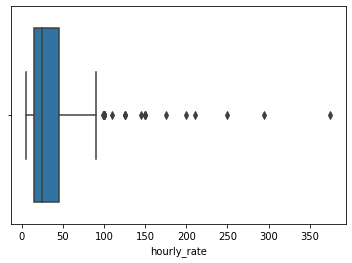

In [35]:
sns.boxplot(dt.hourly_rate)

In [38]:
outliers = dt[dt.hourly_rate > 100]

In [39]:
# Manually inspecting these outliers to determine if they are real data or not
# Remove "sumdude-llc" [2], "michael-lyon-1" [-2], "brian-pegram" [-1]
# The rest of the outliers are real data points . . . so I'm hesitant to remove them
outliers = outliers.iloc[[2,-2,-1],:].index
outliers

Int64Index([553, 967, 968], dtype='int64')

In [40]:
dt = dt.drop(outliers,axis = 0)

# Exploratory Data Analysis - Job Completion Metrics

The purpose of this is to identify users who are successful on the platform. At the highest level I can separate out users who have never completed any jobs and those who have. However, it would be great to dig a little bit deeper. Among those who have completed jobs, who has completed the most jobs? Are the undervaluing themselves or are they correctly valued? This EDA hopes to answer those questions and create a filtered dataset.

Variables:
    - earnings_pst_year: earnings in past year
    - earnings_ever: earnings ever earned. Difference will tell me how successful they were prior to this year.
    - invoices_paid: # of times they've been paid (ever, not just past year)
   
Create:
    - hours_pst_year: earnings / hourly rate; assumes the hourly rate has been constant over the past year
    - worked_pst_year: binary indicator of whether or not they even worked in the past year
        - this is the most basic filtering level
        
Other:
    - Concern of people who've been active for a very short period? If they have earnings then they're good.

## Creating Variables

In [34]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 978
Data columns (total 47 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   profile_url                   979 non-null    object        
 1   city                          979 non-null    object        
 2   state                         979 non-null    object        
 3   country                       979 non-null    object        
 4   rating                        911 non-null    float64       
 5   earnings                      979 non-null    object        
 6   hourly_rate                   979 non-null    int64         
 7   skills_list                   979 non-null    object        
 8   user_description              979 non-null    object        
 9   index_y                       979 non-null    int64         
 10  member_since                  979 non-null    object        
 11  earnings_pst_yr               94

In [35]:
# Converting earnings in past year to numeric
earnings_pst_yr_num = dt.loc[:,'earnings_pst_yr']
earnings_pst_yr_num = earnings_pst_yr_num.str.replace(',','')
earnings_pst_yr_num = earnings_pst_yr_num.str.replace('$','')
earnings_pst_yr_num = earnings_pst_yr_num.str.strip()
earnings_pst_yr_num = pd.to_numeric(earnings_pst_yr_num)

dt.loc[:,'earnings_pst_yr'] = earnings_pst_yr_num

In [36]:
# Creating Earnings per Month (Earnings Ever / Months Active)
dt['earnings_per_month'] = dt['earnings_ever'] / dt['months_active']

In [37]:
# Creating Hours Worked Past year
dt['hours_worked'] = dt['earnings_pst_yr'] / dt['hourly_rate']

In [38]:
# Creating worked_pst_year
dt['worked_pst_yr'] = 0
dt.loc[dt['earnings_pst_yr'] > 0, 'worked_pst_yr'] = 1

In [39]:
# Creating Hours Worked per Month
dt['hours_worked_pr_mnth'] = ( dt['earnings_ever'] / dt['hourly_rate'] ) / dt['months_active']
dt['hours_worked_pr_mnth_pst_yr'] = ( dt['earnings_pst_yr'] / 12 ) / dt['hourly_rate']

In [40]:
dt.iloc[:,[0,6,12,5,11,48,24]].head()

,profile_url,hourly_rate,earnings_ever,earnings,earnings_pst_yr,hours_worked,months_active
0,https://www.guru.com/freelancers/scopic,24,5633449.0,"$1,338,285/year",1334283.0,55595.125000,203.0
1,https://www.guru.com/freelancers/crazy-program...,60,420661.0,"$110,080/year",110080.0,1834.666667,35.0
2,https://www.guru.com/freelancers/andrii-tsyniuk,50,45320.0,"$45,320/year",45320.0,906.400000,7.0
3,https://www.guru.com/freelancers/tyler-william...,55,9278.0,"$8,000/year",8000.0,145.454545,16.0
4,https://www.guru.com/freelancers/jonathan-ryan...,70,11700.0,"$4,400/year",4400.0,62.857143,72.0


In [48]:
dt[dt['earnings_pst_yr'] < 20].sort_values(['hours_worked_pr_mnth_pst_yr']).iloc[:,[6,12,5,11,48,49,50,51,24]]

,hourly_rate,earnings_ever,earnings,earnings_pst_yr,hours_worked,worked_pst_yr,hours_worked_pr_mnth,hours_worked_pr_mnth_pst_yr,months_active
978,30,200.0,NA,0.0,0.000000,0,0.123457,0.000000,54.0
294,50,118.0,$11/year,11.0,0.220000,1,0.040000,0.018333,59.0
486,70,63341.0,$15/year,16.0,0.228571,1,7.603962,0.019048,119.0
965,15,4.0,$4/year,4.0,0.266667,1,0.029630,0.022222,9.0
547,30,8.0,$8/year,8.0,0.266667,1,0.088889,0.022222,3.0
20,30,14090.0,$8/year,8.0,0.266667,1,10.674242,0.022222,44.0
559,35,2911.0,$10/year,10.0,0.285714,1,2.132601,0.023810,39.0
803,25,8.0,$7/year,8.0,0.320000,1,0.160000,0.026667,2.0
256,15,5.0,$5/year,5.0,0.333333,1,0.027778,0.027778,12.0
161,25,10.0,$10/year,10.0,0.400000,1,0.008511,0.033333,47.0


In [41]:
# Immediately can see outliers. 40 hrs a week x 4 weeks = 160 hours a month
print("Summary statistics for hours_worked_pr_mnth:\n",
      dt.hours_worked_pr_mnth_pst_yr.describe())
print("Count of users with 40hrs per week or less per month:\n",
      dt[dt.hours_worked_pr_mnth_pst_yr <= 160].profile_url.count())
print("Total number of users:\n",
     dt.hours_worked_pr_mnth_pst_yr.count())

# I will want to remove the extreme outliers
dt[dt.hours_worked_pr_mnth_pst_yr > 160].profile_url

Summary statistics for hours_worked_pr_mnth:
 count     948.000000
mean       17.673927
std       160.915070
min         0.000000
25%         0.346726
50%         1.333333
75%         5.419375
max      4632.927083
Name: hours_worked_pr_mnth_pst_yr, dtype: float64
Count of users with 40hrs per week or less per month:
 936
Total number of users:
 948


0                https://www.guru.com/freelancers/scopic
10     https://www.guru.com/freelancers/top-guru-assi...
11     https://www.guru.com/freelancers/eden-programm...
21     https://www.guru.com/freelancers/avion-technol...
22         https://www.guru.com/freelancers/j-consulting
55        https://www.guru.com/freelancers/ken-b-1083572
66       https://www.guru.com/freelancers/kimberly-verdi
109    https://www.guru.com/freelancers/nicholas-f-couch
123              https://www.guru.com/freelancers/dugale
180        https://www.guru.com/freelancers/evan-medrano
264    https://www.guru.com/freelancers/lisamariebrennan
296    https://www.guru.com/freelancers/super-writer-guy
Name: profile_url, dtype: object

In [42]:
# The large majority of my sample works less than 50 hours per month.
# It doesn't even start to drop off much until less than 5 hours per month
# 423 people in the data have worked 1 or fewer hours per month over the past year.

def num_people_by_hours_worked(hour_threshold):
    print("Number of people working less than",
          str(hour_threshold) + ":",dt[dt.hours_worked_pr_mnth_pst_yr < hour_threshold].profile_url.count())
    
for i, val in enumerate([160, 100, 50, 20, 10, 5, 3, 2, 1]):
    num_people_by_hours_worked(val)


Number of people working less than 160: 936
Number of people working less than 100: 918
Number of people working less than 50: 895
Number of people working less than 20: 843
Number of people working less than 10: 779
Number of people working less than 5: 695
Number of people working less than 3: 630
Number of people working less than 2: 539
Number of people working less than 1: 424


In [43]:
# So theory is that the people working alot tend have a lower hourly rate
# And the people working less have a higher hourly rate


def mean_rate_by_hours_worked(hour_threshold):
    print("Mean hourly rate of people working less than",
          str(hour_threshold) + ":", 
          dt[dt.hours_worked_pr_mnth_pst_yr < hour_threshold].hourly_rate.mean())

rate_by_hours = []
for i, val in enumerate([160, 100, 50, 20, 10, 5, 3, 2, 1]):
    mean_rate_by_hours_worked(val)
    
# Wow, there is a TINY difference

Mean hourly rate of people working less than 160: 32.0940170940171
Mean hourly rate of people working less than 100: 32.173202614379086
Mean hourly rate of people working less than 50: 32.29832402234637
Mean hourly rate of people working less than 20: 32.54685646500593
Mean hourly rate of people working less than 10: 33.215661103979464
Mean hourly rate of people working less than 5: 33.65179856115108
Mean hourly rate of people working less than 3: 34.234920634920634
Mean hourly rate of people working less than 2: 35.142857142857146
Mean hourly rate of people working less than 1: 36.85849056603774


In [56]:
def mean_rate_by_hours_worked_by_skill(hour_threshold, skill_category, verbose = True):
    tmp = dt[(dt.hours_worked_pr_mnth_pst_yr < hour_threshold) & dt[skill_category] == 1].hourly_rate.mean()
    
    if verbose == True:
        print("Mean hourly rate of people working less than",
              str(hour_threshold) + ":",
              tmp)
    return tmp
    
for i, val in enumerate([160, 100, 50, 20, 10, 5, 3, 2, 1]):
    mean_rate_by_hours_worked_by_skill(val, 'engineering & architecture')

Mean hourly rate of people working less than 160: 42.16
Mean hourly rate of people working less than 100: 43.5
Mean hourly rate of people working less than 50: 44.04225352112676
Mean hourly rate of people working less than 20: 44.52857142857143
Mean hourly rate of people working less than 10: 45.36923076923077
Mean hourly rate of people working less than 5: 46.68421052631579
Mean hourly rate of people working less than 3: 48.62
Mean hourly rate of people working less than 2: 54.64102564102564
Mean hourly rate of people working less than 1: 59.70967741935484


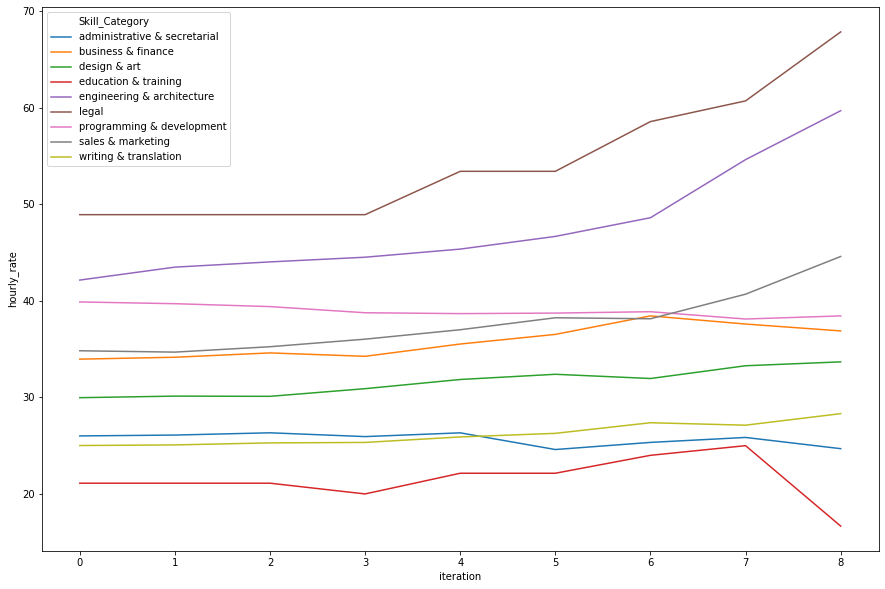

In [58]:
# Let's drill into a specific subgroup and see if it holds

skills = ['administrative & secretarial','business & finance', 'design & art', 'education & training',
          'engineering & architecture', 'legal', 'programming & development','sales & marketing', 
          'writing & translation']

hr_by_skill = {}
for j, skill_val in enumerate(skills):
    
    rate_by_hours = []
    for i, val in enumerate([160, 100, 50, 20, 10, 5, 3, 2, 1]):
        hrate = mean_rate_by_hours_worked_by_skill(val, skill_val, verbose = False)
        rate_by_hours.append(hrate)
    
    hr_by_skill.update({skill_val: rate_by_hours})

# Cleaning
hr_by_skill_pd = pd.DataFrame(hr_by_skill).stack()
hr_by_skill_pd = hr_by_skill_pd.reset_index()
#hr_by_skill_pd = hr_by_skill_pd.drop(['level_0'], axis = 1)
hr_by_skill_pd.columns = ['iteration','Skill_Category','hourly_rate']

# Plotting
plt.figure(figsize=(15,10))
sns.lineplot(x = hr_by_skill_pd.iteration, y = hr_by_skill_pd.hourly_rate, 
             hue = hr_by_skill_pd.Skill_Category)

# The left most side is includes people who worked alot. The right most side is for those who barely worked.

In [321]:
# Repeating the above but with buckets
dt['quantile_4'] = pd.qcut(dt['hours_worked_pr_mnth_pst_yr'], q=4)
dt['quantile_8'] = pd.qcut(dt['hours_worked_pr_mnth_pst_yr'], q=8)
dt['quantile_10'] = pd.qcut(dt['hours_worked_pr_mnth_pst_yr'], q=10)

# Summary Stats
display("Hourly Rate by Quantiles (4):",
      dt.groupby(['quantile_4'])[['hours_worked_pr_mnth_pst_yr','hourly_rate']].mean())
display("Hourly Rate by Quantiles (8):",
      dt.groupby(['quantile_8'])[['hours_worked_pr_mnth_pst_yr','hourly_rate']].mean())
display("Hourly Rate by Quantiles (10):",
      dt.groupby(['quantile_10'])[['hours_worked_pr_mnth_pst_yr','hourly_rate']].mean())

# The idea here is to try and define who the "successful" people are
# Doesn't seem to be working out. It's returning values as expected, but I'm not sure what to do with it.
# The most obvious one is quantile 4, pick the two middle quantiles to be my "successful" group where
# hourly_rate stabilizes at 30 and for the group with fewer jobs its 39 and for the group with more jobs its
# only a little bit lower.
# I could take the 10 split and just combine to make it how I like, actually. So leave out the edge cases
# and train on the successful middle.

'Hourly Rate by Quantiles (4):'

,hours_worked_pr_mnth_pst_yr,hourly_rate
quantile_4,,
"(-0.001, 0.346]",0.165974,39.189873
"(0.346, 1.333]",0.730223,30.599156
"(1.333, 5.425]",2.816297,29.737288
"(5.425, 4632.927]",66.992497,26.831224


'Hourly Rate by Quantiles (8):'

,hours_worked_pr_mnth_pst_yr,hourly_rate
quantile_8,,
"(-0.001, 0.163]",0.090977,44.411765
"(0.163, 0.346]",0.241606,33.923729
"(0.346, 0.667]",0.498828,33.195122
"(0.667, 1.333]",0.979886,27.798246
"(1.333, 2.5]",1.914603,31.478992
"(2.5, 5.425]",3.733405,27.965812
"(5.425, 16.616]",9.712990,26.771186
"(16.616, 4632.927]",123.790663,26.890756


'Hourly Rate by Quantiles (10):'

,hours_worked_pr_mnth_pst_yr,hourly_rate
quantile_10,,
"(-0.001, 0.139]",0.083149,41.638095
"(0.139, 0.251]",0.194258,38.047059
"(0.251, 0.462]",0.348985,37.840426
"(0.462, 0.75]",0.594236,28.760417
"(0.75, 1.333]",1.035159,27.829787
"(1.333, 2.236]",1.795260,30.787234
"(2.236, 3.796]",2.888874,30.389474
"(3.796, 8.184]",5.723903,27.382979
"(8.184, 23.14]",13.627475,26.073684


In [316]:
# Tentative Grouping is quantile 10_4 to 10_8
# There is a clear uptick on group 10_3, _2, _1, but less of a drop off in _10, _9.
# What I don't have is a clear argument that these people have priced themselves appropriately.
# Before I decide I should try to split out 10_8, _9, _10 more

In [54]:
subset_quantiles = dt
subset_quantiles['quantile'] = pd.qcut(subset_quantiles[subset_quantiles['hours_worked_pr_mnth_pst_yr'] >= 8.184].hours_worked_pr_mnth_pst_yr,
                                          q=5)
display("Hourly Rate by Quantiles (X):",
        subset_quantiles.groupby(['quantile'])[['hourly_rate']].mean())

skills = ['administrative & secretarial','business & finance', 'design & art', 'education & training',
          'engineering & architecture', 'legal', 'programming & development','sales & marketing', 
          'writing & translation']

display(subset_quantiles.groupby(['quantile'])[skills].sum())

# Clearly imbalance on the skill category. Going to need to split it out by skill category.

for i, val in enumerate(skills):
    display("Hourly Rate by Quantiles for " + val +":",
            subset_quantiles[subset_quantiles[val] == 1].groupby(['quantile'])[['hourly_rate']].mean())

'Hourly Rate by Quantiles (X):'

,hourly_rate
quantile,
"(8.199, 11.667]",26.717949
"(11.667, 17.113]",22.432432
"(17.113, 30.05]",30.605263
"(30.05, 66.429]",27.342105
"(66.429, 4632.927]",24.947368


,administrative & secretarial,business & finance,design & art,education & training,engineering & architecture,legal,programming & development,sales & marketing,writing & translation
quantile,,,,,,,,,
"(8.199, 11.667]",3,7,12,1,2,0,2,8,14
"(11.667, 17.113]",5,5,8,0,4,2,8,8,12
"(17.113, 30.05]",5,3,7,1,1,0,11,10,14
"(30.05, 66.429]",4,7,6,0,0,0,12,6,14
"(66.429, 4632.927]",4,5,7,0,5,0,12,10,7


'Hourly Rate by Quantiles for administrative & secretarial:'

,hourly_rate
quantile,
"(8.199, 11.667]",45.00
"(11.667, 17.113]",14.60
"(17.113, 30.05]",27.60
"(30.05, 66.429]",39.50
"(66.429, 4632.927]",18.75


'Hourly Rate by Quantiles for business & finance:'

,hourly_rate
quantile,
"(8.199, 11.667]",15.285714
"(11.667, 17.113]",26.600000
"(17.113, 30.05]",28.333333
"(30.05, 66.429]",35.285714
"(66.429, 4632.927]",20.000000


'Hourly Rate by Quantiles for design & art:'

,hourly_rate
quantile,
"(8.199, 11.667]",23.750000
"(11.667, 17.113]",17.000000
"(17.113, 30.05]",16.428571
"(30.05, 66.429]",22.500000
"(66.429, 4632.927]",9.714286


'Hourly Rate by Quantiles for education & training:'

,hourly_rate
quantile,
"(8.199, 11.667]",5.0
"(11.667, 17.113]",NaN
"(17.113, 30.05]",30.0
"(30.05, 66.429]",NaN
"(66.429, 4632.927]",NaN


'Hourly Rate by Quantiles for engineering & architecture:'

,hourly_rate
quantile,
"(8.199, 11.667]",40.00
"(11.667, 17.113]",38.25
"(17.113, 30.05]",10.00
"(30.05, 66.429]",NaN
"(66.429, 4632.927]",8.00


'Hourly Rate by Quantiles for legal:'

,hourly_rate
quantile,
"(8.199, 11.667]",NaN
"(11.667, 17.113]",17.5
"(17.113, 30.05]",NaN
"(30.05, 66.429]",NaN
"(66.429, 4632.927]",NaN


'Hourly Rate by Quantiles for programming & development:'

,hourly_rate
quantile,
"(8.199, 11.667]",25.000000
"(11.667, 17.113]",37.500000
"(17.113, 30.05]",46.818182
"(30.05, 66.429]",46.250000
"(66.429, 4632.927]",42.083333


'Hourly Rate by Quantiles for sales & marketing:'

,hourly_rate
quantile,
"(8.199, 11.667]",39.125000
"(11.667, 17.113]",19.625000
"(17.113, 30.05]",29.500000
"(30.05, 66.429]",13.333333
"(66.429, 4632.927]",26.000000


'Hourly Rate by Quantiles for writing & translation:'

,hourly_rate
quantile,
"(8.199, 11.667]",19.285714
"(11.667, 17.113]",16.583333
"(17.113, 30.05]",27.357143
"(30.05, 66.429]",17.785714
"(66.429, 4632.927]",19.285714


In [55]:
# Found a good example: thomas straub vs beksconsulting
# Thomas straub is charging 8$ and has very small total earnings
# Beksconsulting, however, is charging 60$ and has earned WAYYYY more.
# Therefore, Thomas Straub likely could charge much. much more.
# The question, however, is how can I identify successful people, like beksconsulting?
# If I'm trying to separate people out by hours worked per month in the past year, it 
# lumps together Straub and beks. In fact, straub worked much much less than beks.
# Therefore, by the logic of the theory, Straub is charging too much. This clearly isn't the case.

# The most logical way to split these two up is to see that beks is charging more, for similar services,
# and is very successful working many more hours per month.
# To generalize that: find people with similar services and examine the distribution of hourly rates
# In the ideal world, this would be normally distributed. Then among these I can plot hourly rates
# against the hours worked per month in the past year. I would hope to see that those with
# higher hourly rates work slightly less than those with lower hourly rates, a curve.

dt[(dt['hours_worked_pr_mnth_pst_yr'] >= 17.113) & dt['programming & development'] == 1].profile_url

1      https://www.guru.com/freelancers/crazy-program...
11     https://www.guru.com/freelancers/eden-programm...
12             https://www.guru.com/freelancers/ken-gold
14         https://www.guru.com/freelancers/james-mays-1
23     https://www.guru.com/freelancers/smart-softwar...
24         https://www.guru.com/freelancers/marco-samson
25        https://www.guru.com/freelancers/empiricaledge
26        https://www.guru.com/freelancers/edgar-bolivar
27     https://www.guru.com/freelancers/michael-kowalski
28     https://www.guru.com/freelancers/optisol-business
44       https://www.guru.com/freelancers/johnny-vencill
45           https://www.guru.com/freelancers/sakthiguru
46     https://www.guru.com/freelancers/john-son-1494196
47           https://www.guru.com/freelancers/reddensoft
50       https://www.guru.com/freelancers/beksconsulting
51         https://www.guru.com/freelancers/stephenwhite
55        https://www.guru.com/freelancers/ken-b-1083572
65           https://www.guru.c

In [56]:
dt.iloc[[50,604],:]

,profile_url,city,state,country,rating,earnings,hourly_rate,skills_list,user_description,index_y,...,legal,programming & development,sales & marketing,writing & translation,earnings_per_month,hours_worked,worked_pst_yr,hours_worked_pr_mnth,hours_worked_pr_mnth_pst_yr,quantile
50,https://www.guru.com/freelancers/beksconsulting,Krum,Texas,United States,100.0,"$82,000/year",60,Business Intelligence,Microsoft-certified SQL Server guru providing ...,10,...,0,1,0,0,5504.575269,1366.666667,1,91.742921,113.888889,"(66.429, 4632.927]"
605,https://www.guru.com/freelancers/thomas-straub,Houston,Texas,United States,100.0,"$2,381/year",8,Apache,"Using technologies such as HTML, CSS, SEO, Jav...",15,...,0,1,0,0,153.154472,297.625000,1,19.144309,24.802083,"(17.113, 30.05]"


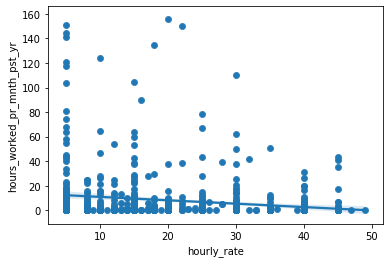

In [61]:
# Plotting "success" metric - hours worked per month in the past year (assumes constant hourly rate)
# against hourly rate. Idea is that people on the bottom of the graph are pricing themselves too high
# whereas those with many hours worked are pricing themselves either too low or adequately.
# Thus, I still have two issues:
# 1. Where do I draw the split? How many hours worked per month in the past year must a user have to be successful?
# 2. How can I separate out users who are priced too high and those who are priced correctly?
plt_dt = dt[cols]
sns.scatterplot(x = 'hourly_rate', y = 'hours_worked_pr_mnth_pst_yr',
                data = plt_dt[(plt_dt['hours_worked_pr_mnth_pst_yr'] < 160) & (plt_dt['hourly_rate'] < 50)])
sns.regplot(x = 'hourly_rate', y = 'hours_worked_pr_mnth_pst_yr',
            data = plt_dt[(plt_dt['hours_worked_pr_mnth_pst_yr'] < 160) & (plt_dt['hourly_rate'] < 50)],
            lowess=False)

writing & translation


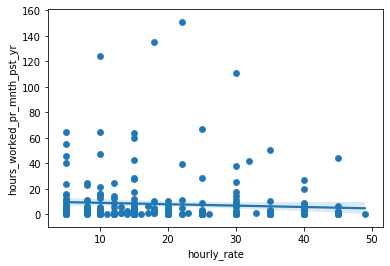

In [57]:
# Trying the scatter plot logic I described a couple of cells prior
cols = ['administrative & secretarial','business & finance', 'design & art', 'education & training',
          'engineering & architecture', 'legal', 'programming & development','sales & marketing', 
          'writing & translation', 'hourly_rate', 'hours_worked_pr_mnth_pst_yr']

plt_dt = dt[cols]
plt_skill_category = cols[8]
print(plt_skill_category)
sns.scatterplot(x = 'hourly_rate', y = 'hours_worked_pr_mnth_pst_yr',
                data = plt_dt[(plt_dt['hours_worked_pr_mnth_pst_yr'] < 160) & (plt_dt[plt_skill_category] == 1) & (plt_dt['hourly_rate'] < 50)])
sns.regplot(x = 'hourly_rate', y = 'hours_worked_pr_mnth_pst_yr',
                data = plt_dt[(plt_dt['hours_worked_pr_mnth_pst_yr'] < 160) & (plt_dt[plt_skill_category] == 1) & (plt_dt['hourly_rate'] < 50)],
           lowess=False)


# There isn't really any discernable trend relating hourly_rate and hours_worked_pr_mnth_pst_yr
# This says to me that determining a line at which to divide everyone up isn't easy.
# I could try using a random forest with hours_worked_pr_mnth_pst_yr as the input and hourly_rate
# as the output. The idea being: let the tree find where to split hourly rate, and order terminal nodes
# from lowest mean hourly rate to the largest. Use the cut-offs the tree decides on?

In [62]:
# 6/17/20: Talked with Genna
# On a good track here is what I still need to do:
# Set a success threshold based on the number of hours worked. This may differ by category
# Among those who I deem successful plot the hourly rate distribution.
# Assume that those in the middle have the appropriate hourly rate
# Then plot, with respect to that distribution, the unnsuccessful people.
# Recommend that the outliers move towards the mean.
# Do this by subgroups?

In [ ]:
# So still back to trying what I should set the sucess threshold at.
# Rough definition: Success is working as much as you want to work
# if you want to work 40 hours a week, then success is setting your rate to work that much
# 

In [83]:
dt[skills].sum()

administrative & secretarial    100
business & finance              115
design & art                    222
education & training              9
engineering & architecture       77
legal                            17
programming & development       181
sales & marketing               200
writing & translation           332
dtype: int64

1.2458333333333333

8.392365710566239

102

15.0

25.0

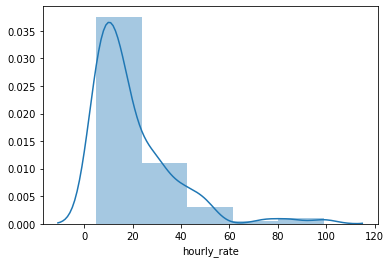

In [119]:
cut_off = 3
display(dt[dt['writing & translation'] == 1].hours_worked_pr_mnth_pst_yr.median())
display(dt[dt['writing & translation'] == 1].hours_worked_pr_mnth_pst_yr.mean())
display(dt[(dt.hours_worked_pr_mnth_pst_yr > cut_off) & (dt['writing & translation'] == 1)].hourly_rate.count())
display(dt[(dt.hours_worked_pr_mnth_pst_yr > cut_off) & (dt['writing & translation'] == 1)].hourly_rate.median())
display(dt[(dt.hours_worked_pr_mnth_pst_yr <= cut_off) & (dt['writing & translation'] == 1)].hourly_rate.median())
sns.distplot(dt[(dt.hours_worked_pr_mnth_pst_yr > cut_off) & (dt['writing & translation'] == 1)].hourly_rate, bins=5)

In [116]:
# Let's try and graph this. For each cutoff calculate the difference in the median hourly rate (above vs below).
# Save that value to a list, and plot it a line plot of all of them.


def median_dif_at_cutoff(cut_off):
    med_above = dt[(dt.hours_worked_pr_mnth_pst_yr > cut_off) & (
        dt['writing & translation'] == 1)].hourly_rate.median()
    med_below = dt[(dt.hours_worked_pr_mnth_pst_yr <= cut_off) & (
        dt['writing & translation'] == 1)].hourly_rate.median()
    
    n_above = dt[(dt.hours_worked_pr_mnth_pst_yr > cut_off) & (
        dt['writing & translation'] == 1)].hourly_rate.count()
    n_below = dt[(dt.hours_worked_pr_mnth_pst_yr <= cut_off) & (
        dt['writing & translation'] == 1)].hourly_rate.count()
    
    med_dif = med_above - med_below
    
    return med_dif, n_above, n_below


wt_med_difs = []
cut_offs = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.4, 0.8]

for i, val in enumerate(cut_offs):
    wt_med_difs.append(median_dif_at_cutoff(val))
    
wt_med_difs

# This doesn't really work. I'm just engineering the cut-off to give me a good result.

[(-10.0, 325, 1),
 (-30.0, 323, 3),
 (-10.0, 317, 9),
 (-15.0, 311, 15),
 (-17.5, 306, 20),
 (-15.0, 303, 23),
 (-7.0, 279, 47),
 (-7.0, 258, 68),
 (-7.5, 228, 98),
 (-10.0, 180, 146)]

count    12.000000
mean     27.333333
std      26.725314
min       5.000000
25%       9.500000
50%      15.000000
75%      32.500000
max      85.000000
Name: hourly_rate, dtype: float64

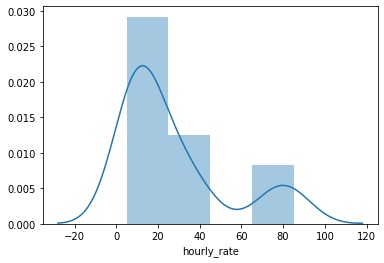

In [143]:
# What if I set it up like this: Tell me how many hours you want to work.
# Find people who look like you and work T hours a month. What is the distribution of their hourly rates?

display(dt[(dt.hours_worked_pr_mnth_pst_yr > 20) & (dt['writing & translation'] == 1) & (
    dt.hours_worked_pr_mnth_pst_yr < 30)].hourly_rate.describe())
sns.distplot(dt[(dt.hours_worked_pr_mnth_pst_yr > 20) & (dt['writing & translation'] == 1) & (
    dt.hours_worked_pr_mnth_pst_yr < 30)].hourly_rate)

In [145]:
# Taking hours per month someone wants to work, doing a lookup on the data (among similar users),
# and extracting the median rate.
med_rate = dt[(dt.hours_worked_pr_mnth_pst_yr > 20) & (dt['writing & translation'] == 1) & (
    dt.hours_worked_pr_mnth_pst_yr < 30)].hourly_rate.describe()[5]
display(med_rate)

avg_decrease = (dt[(dt.hours_worked_pr_mnth_pst_yr < 20) & (
    dt['writing & translation'] == 1)].hourly_rate - med_rate).mean()
display(avg_decrease)

avg_increase = (dt[(dt.hours_worked_pr_mnth_pst_yr > 30) & (
    dt['writing & translation'] == 1)].hourly_rate - med_rate).mean()
display(avg_increase)

# People who work infrequently set their hourly rates $10.33 too high, on average.
# You are setting your hourly rate $10.33 below them, but will be more competitive with users
# with similar skills and who work as much as you would like, on the platform.
# If you work 20-30 hours per month at your set rate then you'll make between 300 and 450. 
# I'm going to create a new script that tries to implement this. 

15.0

10.334470989761092

3.2857142857142856

In [ ]:
# With the above, very simple model, in hand maybe I could then go on to suggest which features are most
# impactful with ever getting a job?

# Exploring how to define "Had a Job"

Instead of predicting hourly rate, I can use the above tool thing to do it. Then I can run a predictive model to relate characteristics of someone's profile and whether or not they've had work. With that model I can say "Hey, if you do X it will improve the probability that you get a job".

The problem is defining "had a job". I could define it as "people who have as many hours worked as you would like". This, however, would involve training a new model everytime. Maybe for this I can just use some hard cut-off and train a model on the "most successful people" on the platform because it is probably invariant across disciplines. Therefore, I can label top vs not performers and train a model on profile characteristics to predict top performer.

Characteristics:
    - Has profile picture
    - Feature extractions from bio
    - Has background picture
    - Has feedback
    - Has portfolio

### Last Step: Making a dataset with state dummies

In [150]:
# Making State dummy variables
state_dummies = pd.get_dummies(dt['state'])
dt_state_dummies = pd.concat([dt, state_dummies], axis=1)

## Saving out Dataset - No State Dummies

1. First printing the columns I have for reference.
2. Saving it to a new table in the postgreSQL database

In [148]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 976 entries, 0 to 978
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   profile_url                   976 non-null    object        
 1   city                          976 non-null    object        
 2   state                         976 non-null    object        
 3   country                       976 non-null    object        
 4   rating                        910 non-null    float64       
 5   earnings                      976 non-null    object        
 6   hourly_rate                   976 non-null    int64         
 7   skills_list                   976 non-null    object        
 8   user_description              976 non-null    object        
 9   index_y                       976 non-null    int64         
 10  member_since                  976 non-null    object        
 11  earnings_pst_yr               94

In [154]:
col_locs = [0,6,26,28,31,32,33,34,38,39,40,41,42,43,44,45,46,51]
print(col_locs)

[0, 6, 26, 28, 31, 32, 33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 46, 51]


In [155]:
# Cleaning to just variables that will be used in the model
analysis_dt = dt.iloc[:,col_locs]
analysis_dt = analysis_dt.dropna()  # Removing people with NA
analysis_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 978
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   profile_url                   947 non-null    object 
 1   hourly_rate                   947 non-null    int64  
 2   num_skills                    947 non-null    int64  
 3   first_skill                   947 non-null    object 
 4   bio_length                    947 non-null    int64  
 5   bio_word_count                947 non-null    int64  
 6   avg_word_length               947 non-null    float64
 7   num_stop                      947 non-null    int64  
 8   administrative & secretarial  947 non-null    int64  
 9   business & finance            947 non-null    int64  
 10  design & art                  947 non-null    int64  
 11  education & training          947 non-null    int64  
 12  engineering & architecture    947 non-null    int64  
 13  legal

In [156]:
# Connect to the database and save data to it
engine = create_engine('postgresql://%s:%s@localhost/%s' %
                       (username, pswd, dbname))
analysis_dt.to_sql("analysis_table_hours_worked", engine, if_exists='replace')

### Saving out dataset - Dummies

In [153]:
dt_state_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 976 entries, 0 to 978
Columns: 103 entries, profile_url to Wyoming
dtypes: category(1), datetime64[ns](1), float64(11), int64(20), object(20), uint8(50)
memory usage: 453.0+ KB


In [116]:
col_locs = [0,6,26,28,31,32,33,34]
x = list(range(38,96))
col_locs.extend(x)
print(col_locs)

[0, 6, 26, 28, 31, 32, 33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]


In [117]:
# Cleaning to just variables that will be used in the model
analysis_dt = dt_state_dummies.iloc[:,col_locs]
analysis_dt = analysis_dt.dropna()  # Removing people with NA
analysis_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 976 entries, 0 to 978
Data columns (total 66 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   profile_url                   976 non-null    object 
 1   hourly_rate                   976 non-null    int64  
 2   num_skills                    976 non-null    int64  
 3   first_skill                   976 non-null    object 
 4   bio_length                    976 non-null    int64  
 5   bio_word_count                976 non-null    int64  
 6   avg_word_length               976 non-null    float64
 7   num_stop                      976 non-null    int64  
 8   administrative & secretarial  976 non-null    int64  
 9   business & finance            976 non-null    int64  
 10  design & art                  976 non-null    int64  
 11  education & training          976 non-null    int64  
 12  engineering & architecture    976 non-null    int64  
 13  legal

In [118]:
# Connect to the database and save data to it
engine = create_engine('postgresql://%s:%s@localhost/%s' %
                       (username, pswd, dbname))
analysis_dt.to_sql("analysis_dummies_table", engine, if_exists='replace')

### OLD: Working on clustering the skills

1. This didn't work. I think the reason is because I don't have enough skills for each user. Therefore, it can't find enough similarity between them. Maybe I could go back and jump into each users url and scrape their entire skills list? Time consuming.

In [ ]:
# Found K-Modes on stackoverflow
# Following the package documentation
# Ref: https://pypi.org/project/kmodes/
# Ref: https://stackoverflow.com/questions/42639824/python-k-modes-explanation
# Ref: https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering

In [ ]:
# Cleaning column names from the dummies database
skills_table_dummies.columns = skills_table_dummies.columns.str.strip().str.lower().str.replace(
    ' ', '_').str.replace('(', '').str.replace(')', '').str.replace('_', '')

In [ ]:
skills_table_dummies.head()

In [ ]:
# Modeling with K Modes
cost = []
for num_clusters in list(range(20, 30)):
    kmode = KModes(n_clusters=num_clusters, init="Huang", verbose=0)
    kmode.fit_predict(skills_table_dummies)
    cost.append(kmode.cost_)
    print("Finished Cluster: " + str(num_clusters))

In [ ]:
y = np.array([i for i in range(20, 30, 1)])
plt.plot(y, cost)

In [ ]:
kmode = KModes(n_clusters=28, init='Huang', verbose=0)
clusters = kmode.fit_predict(skills_table_dummies)

kmodes = kmode.cluster_centroids_
shape = kmodes.shape

for i in range(shape[0]):
    if sum(kmodes[i, :]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-skills cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i, :]
        for j in skills_table_dummies.columns[np.nonzero(cent)]:
            print(j)

In [ ]:
clust_assigned = km.predict(skills_table_dummies)

In [ ]:
unique, counts = np.unique(clust_assigned, return_counts=True)
dict(zip(unique, counts))

In [ ]:
user_cluster_crosswalk = pd.DataFrame(
    skills_table['profile_url'].unique(), columns=["profile_url"]).sort_values(by="profile_url")
user_cluster_crosswalk['cluster'] = clust_assigned
user_cluster_crosswalk[user_cluster_crosswalk['cluster'] == 0].head()

In [ ]:
# Merging into the skills table to investigate those with "no skills"
tmp = pd.merge(skills_table, user_cluster_crosswalk, on="profile_url")
tmp[tmp['cluster'] == 0]

In [ ]:
# It seems to not be working great.
# Why is it putting so many people into the no skills cluster?

# EDA for the Probability of Getting a Job (0/1)

### Outcome: Probability of getting a job  . . . ever?

1. Need to clean all of this up

In [ ]:
# What about the (obvious) relationship between memebershp time and # of jobs completed
# How strong is the relationship?
# First have to clean the invoices paid variable
dt.invoices_paid = dt.invoices_paid.str.replace(',', '')
dt.invoices_paid = pd.to_numeric(dt.invoices_paid)
dt.invoices_paid.describe()

In [ ]:
# Who is NA? I have a whole bunch of 1s but then some NAs?
# The question for a poisson model is: did they just have no invoices OR
# were they never going to have any invoices.
# Looked at some of them and I'll treat them as zeros. So there are really that many ones?!?
dt[dt.invoices_paid.isna()].head()

In [ ]:
# Assigning zero to the NAs. This is important!!
dt.loc[dt.invoices_paid.isna(), 'invoices_paid'] = 0

In [ ]:
sns.distplot(dt.invoices_paid)

In [ ]:
# Wow, very heavy on the zeros. Let's look closer.
dt.invoices_paid.describe()

In [ ]:
# Ah, so it is truncating at one.
# This is going to be problematic for those who are actually at a value of one.
# I can either rerun the scrape and create something to make the val = 0
# or I can just move forward. . .

# For now I'm going to keep moving forward and treat 1 as 0.
# Note, it is more likely than not that they are = 0

In [ ]:
# Checking dist vs months active (no 1s)
sns.scatterplot(x='months_active', y='invoices_paid',
                data=dt[dt.invoices_paid > 1])

In [ ]:
# A few massive outliers. Going to rough chop it down and replot
invoice_gtr_one = dt.invoices_paid > 1
invoice_ls_2000 = dt.invoices_paid < 2000
sns.scatterplot(x='months_active', y='invoices_paid',
                data=dt[invoice_gtr_one & invoice_ls_2000])

In [ ]:
# hmm, there may be a slight signal but you would expect a stronger trend

In [ ]:
# Checking dist vs years active (no 1s)
sns.scatterplot(x='years_active', y='invoices_paid',
                data=dt[invoice_gtr_one & invoice_ls_2000])
# Slight postive non-linear trend bu there is a HUGE outlier

### Invoices Paid - Notes

It has a weak-ish relationship with time. There are a lot of really heavy users of the platform that dominate the market. Let's zoom into the first year and see what it looks like.

In [ ]:
# Looking at invoices pad in the first few months (among those only active for a shorter period of time)
sns.scatterplot(x='months_active',
                y='invoices_paid',
                data=dt[dt['years_active'] < 2])

In [ ]:
# Calculating invoices / time active
dt['invoices_per_month'] = dt['invoices_paid'] / \
    dt['months_active']
sns.distplot(dt.invoices_per_month)
print(dt.invoices_per_month.describe())

In [ ]:
# Loaded on zero with a long tail. Continues to sell that there are some serious power users.
# Average invoice per month is equal to one, but I left in the 1s that could be zeros. . .
# Real average is likely near zero.

# The question now is: Does this mean differ by any characteristic that I observe in the data?
# For people with a different skill set (Andriod) do they have a higher mean invoice/month rate?
# For people in different regions do they have a higher mean invoice/month rate?
# For people with lower hourly rates do they have a higher mean invoice/month rate??

# The next important step is to figure out how to use the skills data.
# It would be great to try and create clusters of the skills.